# Example for analysis of NanoAOD samples

In this example we don't need any pre-processing of NanoAOD samples and can still use several tools of the tW_scattering repository.

- Get the proper normalization for samples
- Categorize different samples into process categories
- Use coffea processors for the map-reduce step
- Make "nice" histograms


In [1]:
%load_ext autoreload
%autoreload 2

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.nano_analysis import nano_analysis
from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive

In [3]:
from klepto.archives import dir_archive
from processor.std_acumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

overwrite = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'nano_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

year = 2018

# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples()

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['DY', 'TTZ', 'top'], samples, redirector=redirector_ucsd, small=False)

# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
     "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        nano_analysis(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

I'm running now


Preprocessing:   0%|          | 0/149 [00:00<?, ?file/s]

Processing:   0%|          | 0/726 [00:00<?, ?chunk/s]

In [6]:
output['totalEvents']['all']/1e6

178.034597

Full fileset is 180M events, and that's basically just DY and ttbar.

In [17]:
# import the plotting libararies: matplotlib and mplhep

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import numpy as np


# load the functions to make a nice plot from the output histograms
# and the scale_and_merge function that scales the individual histograms
# to match the physical cross section

from plots.helpers import makePlot, scale_and_merge

# define a few axes that we can use to rebin our output histograms

N_bins         = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red     = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins        = hist.Bin('pt', r'$p_{T}\ (GeV)$', 20, 0, 400)
pt_bins2       = hist.Bin('pt', r'$p_{T}\ (GeV)$', np.array([15, 40, 60, 80, 100, 200, 300]))
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins       = hist.Bin('eta', r'$\eta $', 10, -2.5, 2.5)
phi_bins       = hist.Bin('phi', r'$\phi $', 16, -3.2, 3.2)


# define nicer labels and colors

my_labels = {
    nano_mapping['TTW'][0]: 'ttW',
    nano_mapping['TTZ'][0]: 'ttZ',
    nano_mapping['DY'][0]: 'DY',
    nano_mapping['top'][0]: 't/tt+jets',
}

my_colors = {
    nano_mapping['TTW'][0]: '#8AC926',
    nano_mapping['TTZ'][0]: '#FFCA3A',
    nano_mapping['DY'][0]: '#6A4C93',
    nano_mapping['top'][0]: '#1982C4',
}



Data: 0 MC: 20535093.49


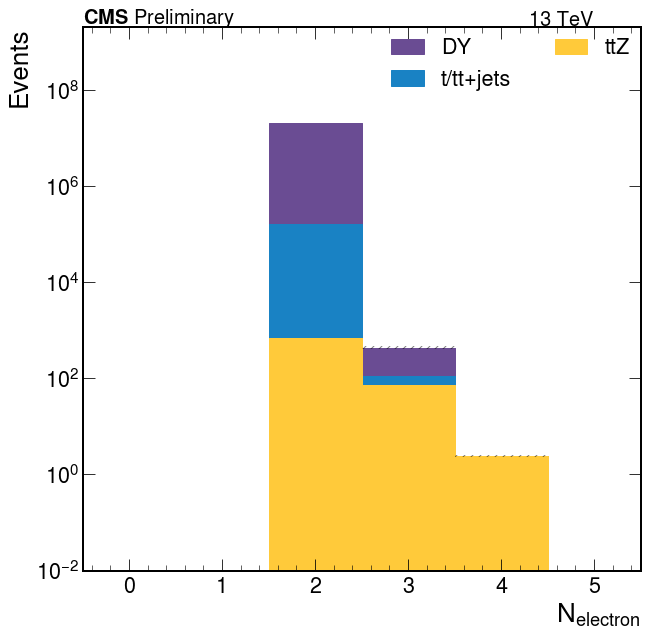

In [8]:
# take the N_ele histogram out of the output, apply the x-secs from samples to the samples in fileset
# then merge the histograms into the categories defined in nano_mapping

my_hist = scale_and_merge(output['N_ele'], samples, fileset, nano_mapping)

# Now make a nice plot of the electron multiplicity.
# You can have a look at all the "magic" (and hard coded monstrosities) that happens in makePlot
# in plots/helpers.py

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 20535093.49


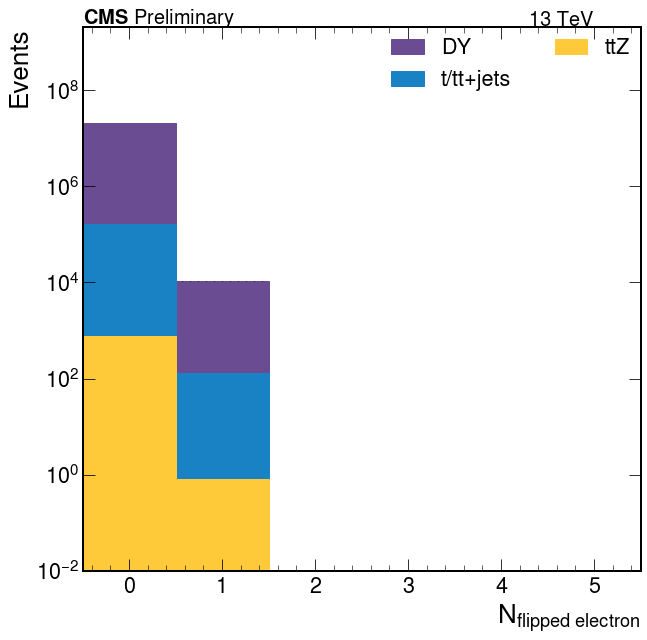

In [9]:
my_hist = scale_and_merge(output['electron_flips'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{flipped\ electron}$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 20535093.49


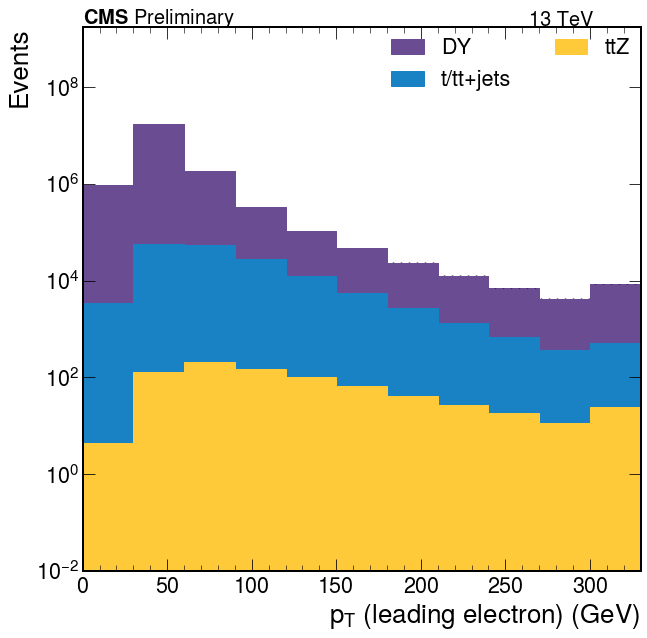

In [10]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (leading\ electron)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 10486.71


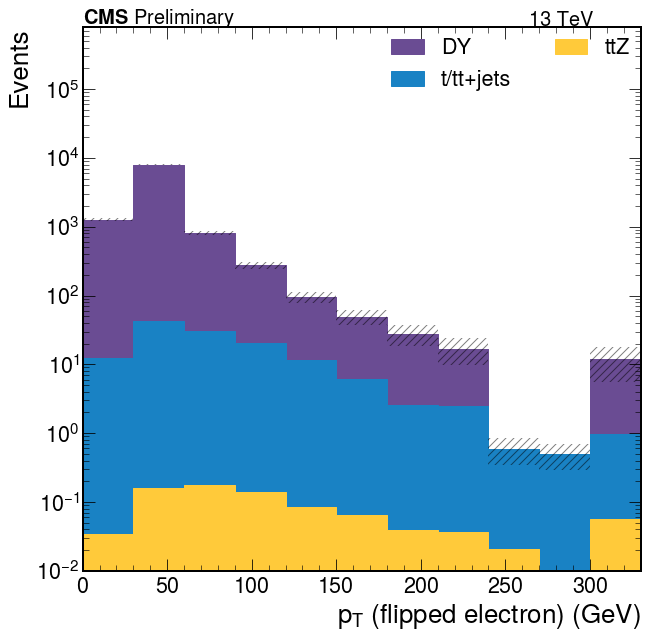

In [11]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (flipped\ electron)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 20535071.62


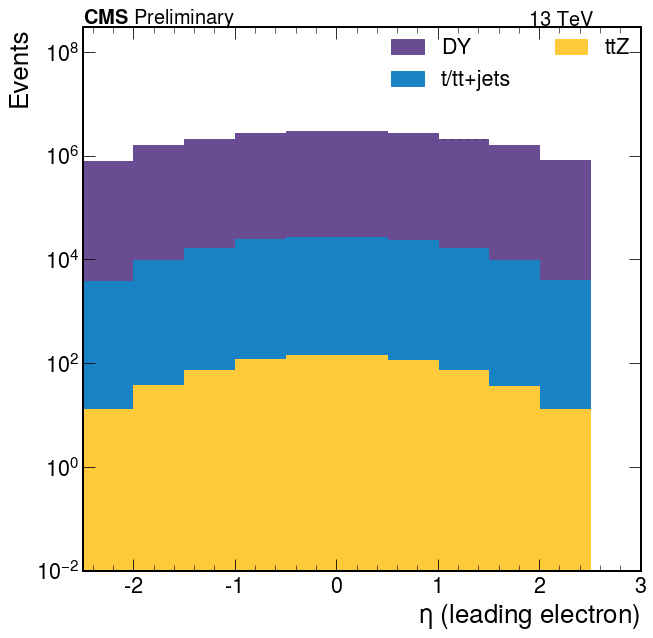

In [18]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (leading\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 10486.71


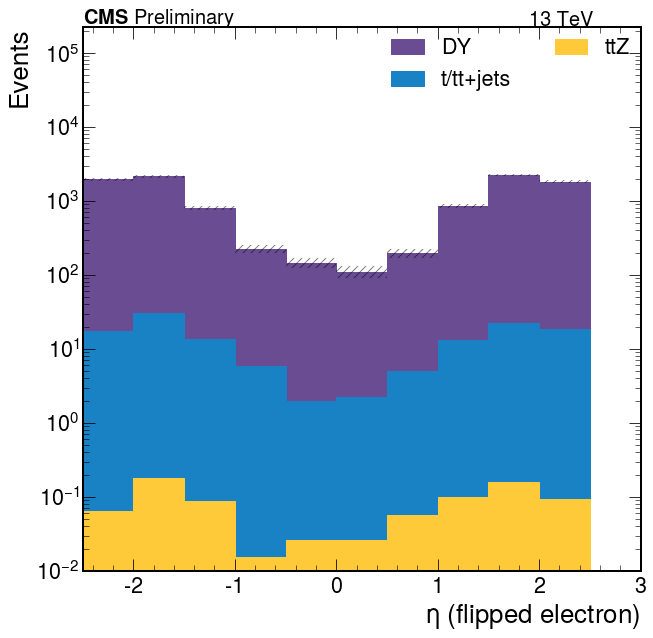

In [19]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (flipped\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

In [22]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'phi',
         bins=phi_bins, log=True, normalize=False, axis_label=r'$\phi\ (leading\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

KeyError: 'No axis phi found in <Hist (dataset,pt,eta) instance at 0x7f02a828eca0>'

Data: 0 MC: 510.4


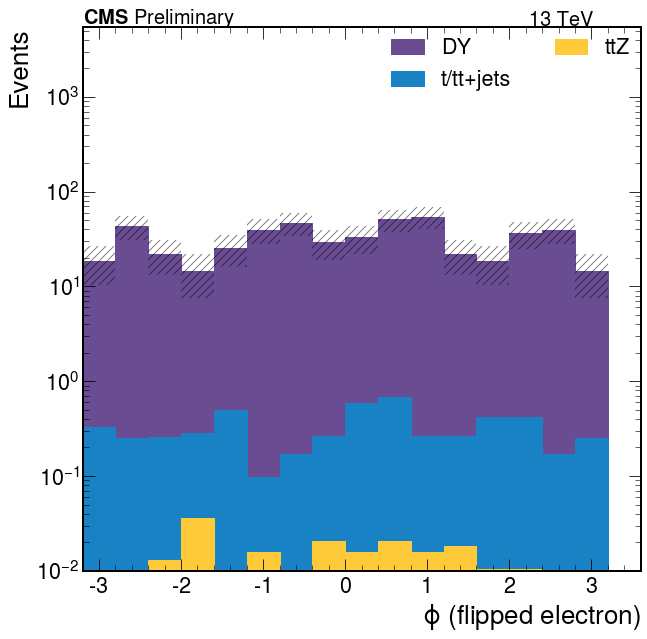

In [37]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'phi',
         bins=phi_bins, log=True, normalize=False, axis_label=r'$\phi\ (flipped\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

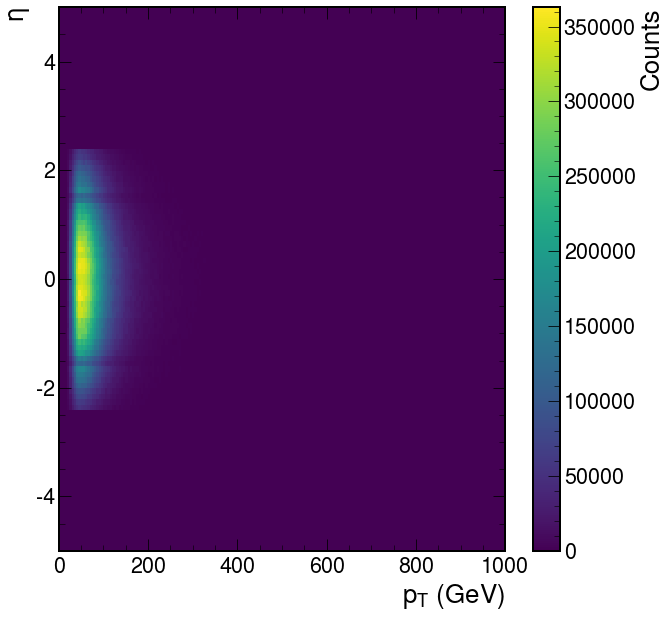

In [20]:
ax = hist.plot2d(
    output['electron'].sum('dataset'),
    xaxis='pt')

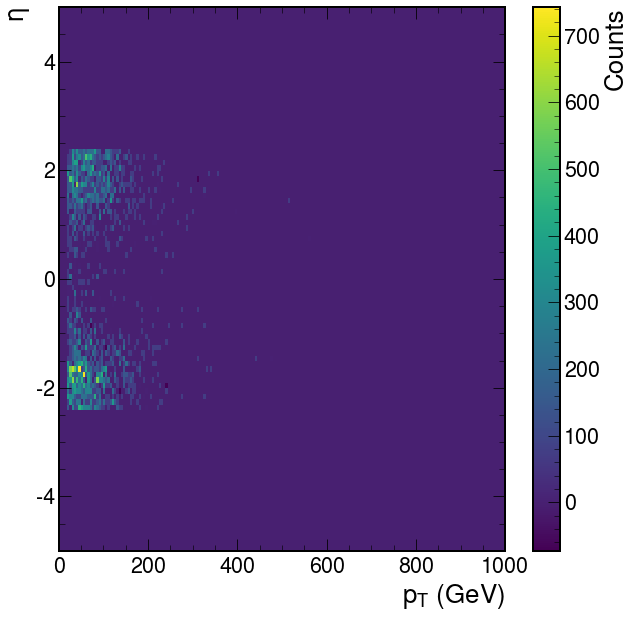

In [21]:
ax = hist.plot2d(
    output['flipped_electron'].sum('dataset'),
    xaxis='pt')

In [22]:
from yahist import Hist1D, Hist2D
import numpy as np

In [25]:
tmp1 = output['flipped_electron'].copy()
tmp1 = tmp1.rebin('eta', eta_bins)
tmp1 = tmp1.rebin('pt', pt_bins2)


tmp2 = output['electron'].copy()
tmp2 = tmp2.rebin('eta', eta_bins)
tmp2 = tmp2.rebin('pt', pt_bins2)

h1 = Hist2D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('pt').edges(), tmp1.axis('eta').edges()),
)


h2 = Hist2D.from_bincounts(
    tmp2.sum('dataset').values()[()].T,
    (tmp2.axis('pt').edges(), tmp2.axis('eta').edges()),
)

In [26]:
h1.divide(h2)

[[ 0.01 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.01 ± 0.00    0.01 ± 0.00]
 [ 0.01 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.01 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
   0.01 ± 0.00    0.01 ± 0.00]]

In [27]:
h1

[[3414.83 ± 58.44   3594.15 ± 59.95   3016.79 ± 54.93   2343.73 ± 48.41
  3141.48 ± 56.05   437.22 ± 20.91]
 [6639.89 ± 81.49   6596.22 ± 81.22   3898.03 ± 62.43   3569.46 ± 59.74
  6053.28 ± 77.80   291.80 ± 17.08]
 [2199.95 ± 46.90   2410.78 ± 49.10   2121.40 ± 46.06   1386.76 ± 37.24
  3436.25 ± 58.62   585.49 ± 24.20]
 [1702.03 ± 41.26   1329.91 ± 36.47   654.10 ± 25.58   654.77 ± 25.59
  436.99 ± 20.90   362.98 ± 19.05]
 [749.85 ± 27.38   373.55 ± 19.33   364.30 ± 19.09    1.00 ± 1.00
  292.38 ± 17.10    1.52 ± 1.23]
 [747.32 ± 27.34   297.85 ± 17.26   145.99 ± 12.08   216.75 ± 14.72
  363.78 ± 19.07   218.61 ± 14.79]
 [1335.48 ± 36.54   669.31 ± 25.87   801.02 ± 28.30   149.45 ± 12.22
  1240.23 ± 35.22   292.34 ± 17.10]
 [2202.42 ± 46.93   2574.65 ± 50.74   1465.84 ± 38.29   1317.63 ± 36.30
  3575.23 ± 59.79   587.18 ± 24.23]
 [4396.39 ± 66.31   3695.57 ± 60.79   3239.67 ± 56.92   2780.69 ± 52.73
  5769.83 ± 75.96   512.92 ± 22.65]
 [2738.08 ± 52.33   3597.08 ± 59.98   4098.57 ± 64.02   1759.79 ± 41.95
  4525.46 ± 67.27   290.28 ± 17.04]]

In [28]:
h2

[[440683.66 ± 663.84   1104341.13 ± 1050.88   856218.89 ± 925.32
  533382.69 ± 730.33   610787.05 ± 781.53   29968.56 ± 173.11]
 [1027398.37 ± 1013.61   2683637.78 ± 1638.18   2217201.37 ± 1489.03
  1405759.49 ± 1185.65   1752604.51 ± 1323.86   116008.24 ± 340.60]
 [1638726.58 ± 1280.13   4293883.43 ± 2072.17   3650075.83 ± 1910.52
  2410164.95 ± 1552.47   3183258.55 ± 1784.17   241676.69 ± 491.61]
 [2273752.77 ± 1507.90   6015612.81 ± 2452.67   5188354.86 ± 2277.80
  3448986.24 ± 1857.14   4772516.14 ± 2184.61   414046.97 ± 643.46]
 [2511659.39 ± 1584.82   6679821.78 ± 2584.54   5841328.51 ± 2416.88
  3971761.23 ± 1992.93   5565310.79 ± 2359.09   513223.17 ± 716.40]
 [2515535.31 ± 1586.04   6702782.19 ± 2588.97   5884475.23 ± 2425.79
  3958406.06 ± 1989.57   5583403.99 ± 2362.92   519908.91 ± 721.05]
 [2259147.13 ± 1503.05   6015907.91 ± 2452.73   5183569.47 ± 2276.75
  3452849.88 ± 1858.18   4764292.88 ± 2182.73   416168.65 ± 645.11]
 [1592303.77 ± 1261.87   4146114.16 ± 2036.20   3547958.95 ± 1883.60
  2339593.70 ± 1529.57   3080315.17 ± 1755.08   249144.91 ± 499.14]
 [1018676.14 ± 1009.29   2601575.04 ± 1612.94   2163989.43 ± 1471.05
  1366670.63 ± 1169.05   1698880.80 ± 1303.41   113039.11 ± 336.21]
 [457160.74 ± 676.14   1132202.57 ± 1064.05   903008.43 ± 950.27
  550017.97 ± 741.63   623842.36 ± 789.84   33115.87 ± 181.98]]